<a href="https://colab.research.google.com/github/FatimaMHelmy/Head-pose-estimation-using-ML-/blob/main/Notebooks/Readme.mdModel_selection_with_normalization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Installatin
> ####  [Media pipe](https://google.github.io/mediapipe/solutions/face_mesh.html) is an open-source cross-platform framework for building multimodel machine learning pipelines.


In [1]:
!pip install mediapipe

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 33.0/33.0 MB 20.8 MB/s eta 0:00:00


### Load the libraries

In [2]:
import mediapipe as mp
import cv2
import time
import numpy as np
import pandas as pd
import os 
from os import path 
import scipy.io as sio  # to read the mat file in the data 
import math 
from math import cos , sin 

### In the above snippet of code, we have first imported the necessary libraries that will help in creating the dataset. Then in the next lines, we are importing the modules required to extract key points and their draw utils. 
>>  The FaceMesh object from the Mediapipe library. This object will detect faces and also detect keypoints from one or more faces.

>>  The VideoCapture object from the OpenCV library. This object will be used for retrieving images from the webcam. We set a parameter on the object with 0 for retrieving images from the webcam.





In [41]:
mp_face_mesh = mp.solutions.face_mesh
#face_mesh = mp_face_mesh.FaceMesh(min_detection_confidence=0.5, min_tracking_confidence=0.5)
face_mesh = mp_face_mesh.FaceMesh(static_image_mode=True, max_num_faces=1,refine_landmarks=True,min_detection_confidence=0.5)
cap = cv2.VideoCapture(0) 

###!!!!!!!!!!!!! Google colab crashes if you try to display image using cv2.imshow() instead import from g::oogle.colab.patches import cv2_imshow and display using cv2_imshow(<image>)

In [3]:
from google.colab.patches import cv2_imshow    


####  For your information, the OpenCV and the Mediapipe library read their image differently.

On the OpenCV library, the image is in BGR color space. Meanwhile, the mediapipe library needs an image with RGB color space.

Therefore, we need to convert the color space to RGB first, apply face landmark detection, then convert it back to BGR color space.

In [4]:
## this function takes the image path and return it's keypoints 
def get_results(img_path): 
      # Read the image 
      ## check first if this img exist or not 
  if os.path.isfile(img_path):    
    image = cv2.imread(img_path)
        # Convert the color space from BGR to RGB
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # To improve performance
    image.flags.writeable = False

        # Get the results [it contains all the landmarks and thire dimentions  ]
    results = face_mesh.process(image)

        # To improve performance
    image.flags.writeable = True

        # Convert the color space from RGB to BGR
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    if (results.multi_face_landmarks) != None:
      return(results,image)
    else:
      return(None , None )  

  else:
    return(None , None )    

In [44]:
# landmarks_indx={1:"nose", 61:"left corner of the mouth", 33:"left corner of the left eye",
#                 199:"chin", 263:"right corner of the right eye", 291:"right corner of the mouth"}
def insert_axis(directory,filename):
  # creat empty dictionry to store points in it after appending them in the dataframe
    data_points_x = dict()
    data_points_y = dict()

    if filename.lower().endswith(('.png', '.jpg', '.jpeg', '.tiff', '.bmp', '.gif')):
      img_path = os.path.join(directory, filename)
        ## call the function get_results to get the image points
      results,image = get_results(img_path)
  #  select required points and store them in data_points dictionary 
      if results != None : 
        ## loop to get points dimentions (x,y)
# start of second loop 
        for key_point in results.multi_face_landmarks:

          for idx,landmark in enumerate(key_point.landmark):

            if idx  :
              if idx == 1:
                nose_dx = (landmark.x)*image.shape[1]
                nose_dy = (landmark.y)*image.shape[0]
              x = landmark.x
              y = landmark.y
               #calculate distance between nose and chin

              # relative_x  =x* image.hape[1]
              # relative_x  =x* image.hape[1]
              ## append dimentions in the data frame 
              data_points_x[f"{idx}"+"_x"] = x 
              data_points_y[f"{idx}"+"_y"] =  y
        # end  of second loop 

        dist_x = data_points_x["263_x"]-data_points_x["1_x"]
        dist_y = data_points_y["263_y"]-data_points_y["1_y"]
        distance = (dist_x**2 + dist_y**2)**0.5
        # normalized to the face position inside the images and center them around the nose 
        for i , j in zip(data_points_x,data_points_y):
          data_points_x[i] = (data_points_x[i] - data_points_x["1_x"])/distance
          data_points_y[j] = (data_points_y[j] - data_points_y["1_y"])/distance
        # conactinate bet two dic to append them in data set 
        data_points_x.update(data_points_y)
        data_points = data_points_x 

    return  data_points ,image ,nose_dx,nose_dy           


In [5]:
def draw_axis(img, pitch,yaw,roll, tdx=None, tdy=None, size = 50):

    yaw = -yaw
    if tdx != None and tdy != None:
        tdx = tdx
        tdy = tdy
    else:
        height, width = img.shape[:2]
        tdx = width / 2
        tdy = height / 2

    # X-Axis pointing to right. drawn in red
    x1 = size * (cos(yaw) * cos(roll)) + tdx
    y1 = size * (cos(pitch) * sin(roll) + cos(roll) * sin(pitch) * sin(yaw)) + tdy

    # Y-Axis | drawn in green
    #        v
    x2 = size * (-cos(yaw) * sin(roll)) + tdx
    y2 = size * (cos(pitch) * cos(roll) - sin(pitch) * sin(yaw) * sin(roll)) + tdy

    # Z-Axis (out of the screen) drawn in blue
    x3 = size * (sin(yaw)) + tdx
    y3 = size * (-cos(yaw) * sin(pitch)) + tdy

    cv2.line(img, (int(tdx), int(tdy)), (int(x1),int(y1)),(0,0,255),3)
    cv2.line(img, (int(tdx), int(tdy)), (int(x2),int(y2)),(0,255,0),3)
    cv2.line(img, (int(tdx), int(tdy)), (int(x3),int(y3)),(255,0,0),2)

    return img

# **MODEL SELECTION**

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Now we have created our dataset, we just have to pick a machine-learning algorithm to classify the poses. In this step, we will take an image, run the blaze pose model (that we used earlier for creating the dataset) to get the key points of the person present in that image, and run our model on that test case. The model is expected to give the correct results with a high confidence score. In this article, I am going to use the SVC(Support Vector Classifier) from the sklearn library to perform the classification task.
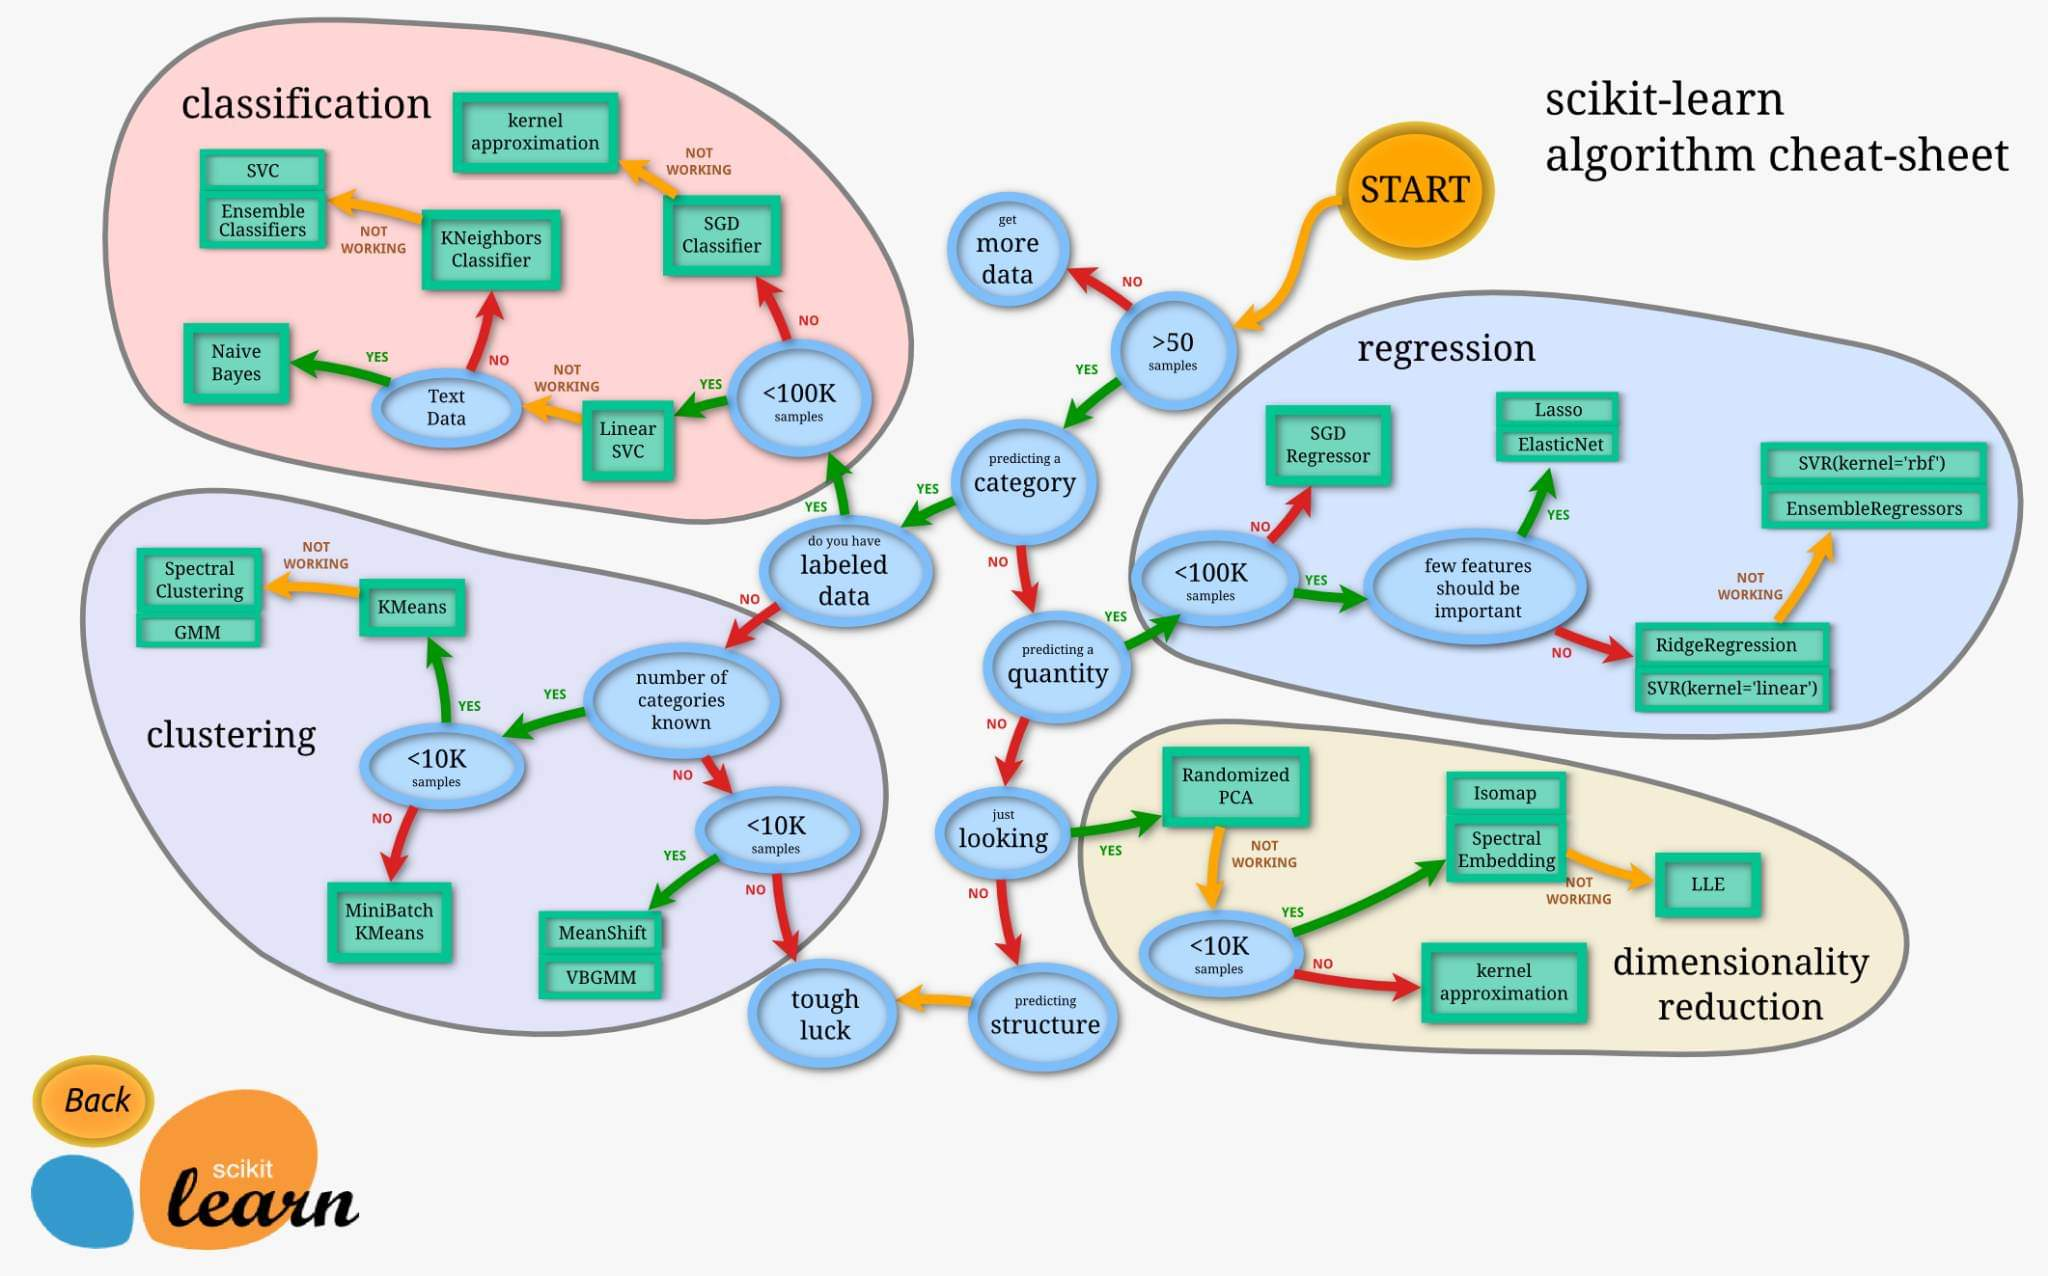

#**data preprocessing**

read the stored data 

In [25]:
face_data_pitch = pd.read_csv("/content/drive/MyDrive/DATA/all_data_with_dis.csv")
face_data_pitch.drop(columns="Unnamed: 0",inplace = True)

# Building a performance-driven model is not a very easy task. It involves refining our model again and again until we get the desired outcome.
 We will use some regression model and fine tune them as possiple 

# Required modules

In [9]:
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.svm import SVR
from sklearn import preprocessing
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.multioutput import MultiOutputRegressor
from sklearn.preprocessing import RobustScaler

## First split data to train and test 

In [27]:
features = face_data_pitch.iloc[:,0:-3]
labels = face_data_pitch.iloc[:,-3:]
X_train, X_test, y_train, y_test = train_test_split( features, labels, test_size=0.2, random_state=42)

In [28]:
y_train

,pitch,yaw,roll
588,-0.086079,-0.538442,0.155857
950,0.580094,0.091731,-0.058140
1633,-0.093529,-0.205006,-0.426006
1564,0.100922,0.192854,-0.106847
1340,-0.174633,-0.074106,0.063739
...,...,...,...
1130,0.175137,-1.213063,-0.160148
1294,-0.164093,-0.038870,-0.023639
860,-0.173406,0.203525,0.112954
1459,0.032837,1.229215,-0.191009


# 1: **USING SVR** 
**We will use two methods for tunning**
>>1 :Tune the parameter by ourselves

>>2: se GrideSearch to get best parameter 

1: Starting with first methods 

In [29]:
## FOR PITCH ANGLE 
def pitch_svr(model):
 # scaler_pitch = StandardScaler()
  scaler_pitch = RobustScaler()
  model_pitch = model 

  # scal features 
  scaled_train_features = scaler_pitch.fit_transform(X_train)
  scaled_test_features = scaler_pitch.transform(X_test)

  # fit train data 
  model_pitch.fit(scaled_train_features, y_train["pitch"])

  # print train & test score 
  print("pitch training score: ",model_pitch.score(scaled_train_features, y_train["pitch"], sample_weight=None))
  print("pitch testing score: ",model_pitch.score(scaled_test_features, y_test["pitch"], sample_weight=None))
  return model_pitch,scaler_pitch
      


In [32]:
model_pitch,scaler_pitch = pitch_svr(SVR( C=100 , coef0=1, epsilon=0.01 ,kernel='rbf'))

pitch training score:  0.25025091715508996
pitch testing score:  0.7860451513346638


In [33]:
## FOR yaw ANGLE 
def yaw_svr(model):
  scaler_yaw = StandardScaler()
  model_yaw = model

  # scal features 
  scaled_train_features = scaler_yaw.fit_transform(X_train)
  scaled_test_features = scaler_yaw.transform(X_test)

  # fit train data 
  model_yaw.fit(scaled_train_features, y_train["yaw"])

  # print train & test score 
  print("yaw training score: ",model_yaw.score(scaled_train_features, y_train["yaw"], sample_weight=None))
  print("yaw testing score: ",model_yaw.score(scaled_test_features, y_test["yaw"], sample_weight=None))

  return model_yaw,scaler_yaw
      

In [34]:
model_yaw,scaler_yaw= yaw_svr(SVR( C=1, coef0=1, epsilon=0.01, kernel='rbf'))

yaw training score:  0.8689512190769177
yaw testing score:  0.9164082624382702


In [17]:
# save model
import pickle
with open('/content/drive/MyDrive/DATA/SVR_yaw.pkl', 'wb') as file:
        pickle.dump(model_yaw, file)

In [35]:
## FOR roll ANGLE 
def roll_svr(model):
  scaler_roll = StandardScaler()
  model_roll = model
  # scal features 
  scaled_train_features = scaler_roll.fit_transform(X_train)
  scaled_test_features = scaler_roll.transform(X_test)

  # fit train data 
  model_roll.fit(scaled_train_features, y_train["roll"])

  # print train & test score 
  print("roll training score: ",model_roll.score(scaled_train_features, y_train["roll"], sample_weight=None))
  print("roll testing score: ",model_roll.score(scaled_test_features, y_test["roll"], sample_weight=None))

  return(model_roll,scaler_roll)
     

In [36]:
model_roll,scaler_roll = roll_svr(SVR(C=150, coef0=1, epsilon=0.001, kernel='rbf'))

roll training score:  0.4146085344439723
roll testing score:  0.8672717154438006


After some trails I found these accuracy are the best but the performance of yaw anlgle isn't satisfied for me. Let's try the second methode

2: Second methode **using grid search to find the best parameter** 


# 3 : using ensemble

In [ ]:
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from math import sqrt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RepeatedKFold
from sklearn.ensemble import BaggingRegressor
from xgboost.sklearn import XGBRegressor
from numpy import arange

In [69]:
axis,img,tdx,tdy = insert_axis("/content/","Character-Concept-art-3d-black-boy.png")

In [70]:
axis_df = pd.DataFrame()
axis_df = axis_df.append(axis,ignore_index=True)
axis_df

,1_x,2_x,3_x,4_x,5_x,6_x,7_x,8_x,9_x,10_x,...,468_y,469_y,470_y,471_y,472_y,473_y,474_y,475_y,476_y,477_y
0,0.0,3.724473,3.624936,3.71773,3.712556,3.695472,2.927276,3.679482,3.674121,3.66281,...,3.242263,3.233724,3.091012,3.24978,3.392386,3.230465,3.228883,3.112318,3.232042,3.346507


In [71]:
img_pitch , image_yaw , img_roll = model_pitch.predict(scaler_pitch.transform(axis_df)), model_yaw.predict(scaler_yaw.transform(axis_df)) , model_roll.predict(scaler_roll.transform(axis_df))

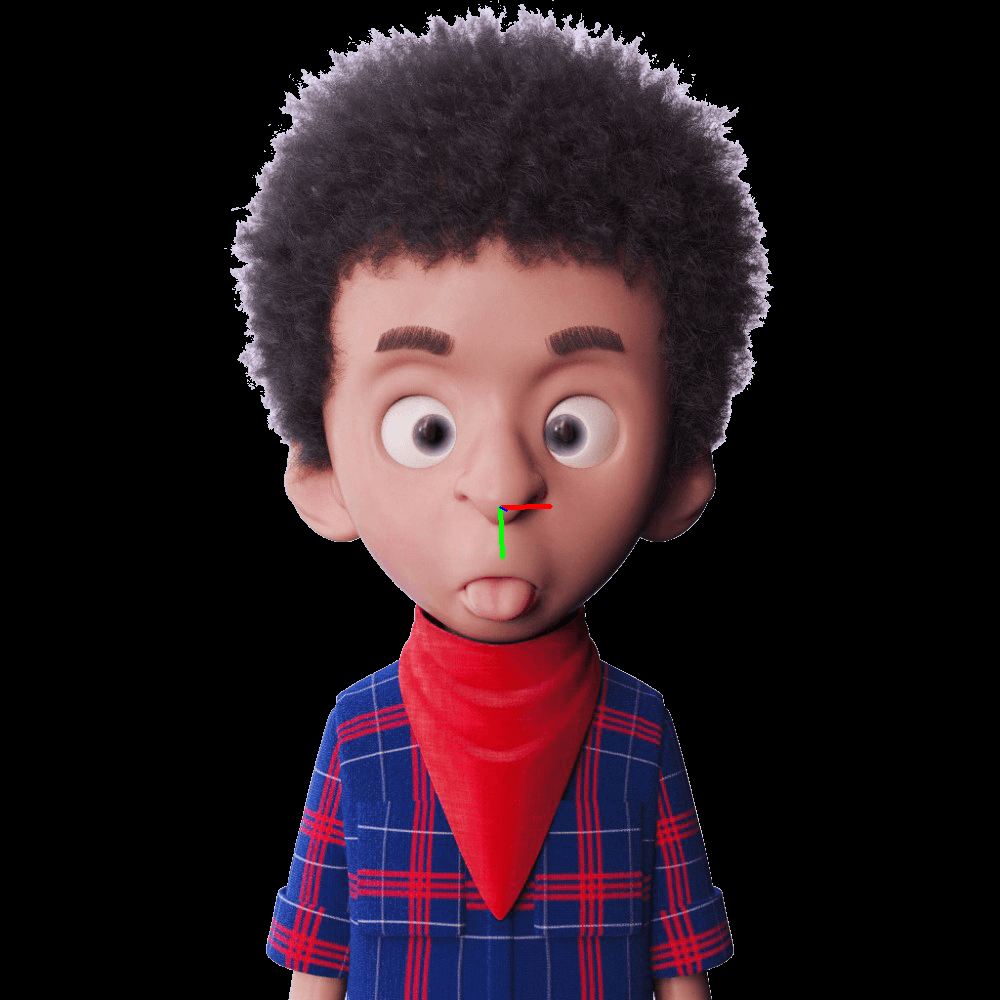

In [72]:
cv2_imshow(draw_axis(img , img_pitch , image_yaw , img_roll , tdx, tdy))

In [ ]:
image = cv2.imread("/content/drive/MyDrive/DATA/AFLW2000/image00002.jpg")
cv2_imshow(draw_axis(image  , np.array(face_data.iloc[0][12]),np.array(face_data.iloc[0][13]) , np.array(face_data.iloc[0][14]), np.array(face_data.iloc[0][0])*image.shape[1] , face_data.iloc[0][1]*image.shape[0]))

In [83]:
X_test.iloc[0]

1_x      0.490042
1_y      0.614157
2_x      0.495709
2_y      0.632544
3_x      0.482789
           ...   
475_y    0.461632
476_x    0.611658
476_y    0.478034
477_x    0.630522
477_y    0.496771
Name: 1559, Length: 954, dtype: float64